# Predict Crime in the UK Using SageMaker

In [3]:
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-linlearn-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [40]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

# Get the data from SageMaker Feature Store

In [5]:
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

feature_group_name = "FG-ndcCrime-7dee9362" # replace with your feature group name 
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [6]:
# Build SQL query to features group
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'
print('Running ' + query_string)

Running SELECT * FROM "fg-ndccrime-7dee9362-1673879553"


In [7]:
# Run Athena query. The output is loaded to a Pandas dataframe.
fs_query.run(query_string=query_string, output_location='s3://'+bucket+'/'+prefix+'/fs_query_results/')
fs_query.wait()
model_data = fs_query.as_dataframe()

In [8]:
model_data.head()

,outcome,gender_male,gender_female,gender_other,age_range_18-24,age_range_25-34,age_range_over_34,age_range_10-17,age_range_under_10,date_month_1,...,date_quarter_2,ethnicity_white,ethnicity_black,ethnicity_asian,ethnicity_other,ethnicity_mixed,coords,write_time,api_invocation_time,is_deleted
0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,...,1.192488e-08,1.0,0.0,0.0,0.0,0.0,0.001633,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.5,...,1.192488e-08,1.0,0.0,0.0,0.0,0.0,0.001633,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.000373,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.002686,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
4,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.002693,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False


In [9]:
#remove unwanted columns
model_data = model_data.drop(['write_time', 'api_invocation_time', 'is_deleted'], axis=1)

In [10]:
model_data.head()

,outcome,gender_male,gender_female,gender_other,age_range_18-24,age_range_25-34,age_range_over_34,age_range_10-17,age_range_under_10,date_month_1,...,date_day_of_year_1,date_day_of_year_2,date_quarter_1,date_quarter_2,ethnicity_white,ethnicity_black,ethnicity_asian,ethnicity_other,ethnicity_mixed,coords
0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,0.001633
1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,0.001633
2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.000373
3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.002686
4,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.002693


In [11]:
# Prepare data SageMaker's Linear Learner algorithm
# Amazon SageMaker's Linear Learner container expects data in CSV data format. 
# Note that the first column must be the target variable and the CSV should not include headers. 

In [12]:
# remove the headers
model_data.columns = range(model_data.shape[1])   # Delete headers

model_data.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,0.001633
1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,0.001633
2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.000373
3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.002686
4,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,...,-0.187718,0.982223,-1.0,1.192488e-08,1.0,0.0,0.0,0.0,0.0,-0.002693


In [13]:
# separate data into train/test data split

#The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy 
#we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))]) 

In [14]:
# Convert data to CSV
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

In [15]:
#copy data to S3 for SageMaker to access
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

# Training

In [16]:
#specify the ECR container location for Amazon SageMaker's implementation of XGBoost

container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [17]:
#Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use 
# as a pointer to the files in S3, which also specify that the content type is CSV.
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator. This includes:

The ll algorithm container
The IAM role to use
Training instance type and count
S3 location for output data
Algorithm hyperparameters
And then a .fit() function which specifies:

S3 location for output data. In this case we have both a training and validation set which are passed in.

In [18]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',
                        eval_metric='auc', num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2023-02-12 02:36:42 Starting - Starting the training job...ProfilerReport-1676169401: InProgress
...
2023-02-12 02:37:26 Starting - Preparing the instances for training......
2023-02-12 02:38:32 Downloading - Downloading input data......
2023-02-12 02:39:38 Training - Training image download completed. Training in progress...Arguments: train
[2023-02-12:02:39:54:INFO] Running standalone xgboost training.
[2023-02-12:02:39:54:INFO] File size need to be processed in the node: 601.88mb. Available memory size in the node: 8603.77mb
[2023-02-12:02:39:54:INFO] Determined delimiter of CSV input is ','
[02:39:54] S3DistributionType set as FullyReplicated
[02:39:55] 1762710x26 matrix with 45830460 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-02-12:02:39:55:INFO] Determined delimiter of CSV input is ','
[02:39:55] S3DistributionType set as FullyReplicated
[02:39:56] 503632x26 matrix with 13094432 entries loaded from /opt/ml/input/data/validation?format

# Model Hosting w/ Endpoint Creation & Model Evaluation
Now that we have successfully trained our model, let’s deploy it and see how it does on the test data!

In [19]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------!

In [20]:
#need to make sure data is in correct format for deployed model
from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
xgb_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [21]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
880546,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.660254e-01,...,0.866025,0.500000,0.000000e+00,1.000000e+00,1.0,0.0,0.0,0.0,0.0,-0.002090
2085095,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.000000e+00,...,-0.960150,0.279486,-1.000000e+00,1.192488e-08,0.0,1.0,0.0,0.0,0.0,-0.028585
1734339,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-8.742278e-08,...,-0.119881,-0.992788,-8.742278e-08,-1.000000e+00,1.0,0.0,0.0,0.0,0.0,-0.056046
1494162,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000e+00,...,0.204552,0.978856,0.000000e+00,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-0.000628
220295,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.660254e-01,...,0.983798,0.179281,0.000000e+00,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-0.004871


# Inference

In [22]:
# run the prediction on a single observation
prediction = xgb_predictor.predict(np.array([1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.8660252094268799,0.5000002980232239,0.2993628978729248,
                                             -0.9541393518447876,0.7071067690849304,0.7071067690849304,-0.8124867677688599,0.582979679107666,
                                             -0.7221164703369141,0.6917715072631836,-1.0,1.1924880638503056e-08,1.0,0.0,0.0,0.0,0.0,
                                             -0.0260128165460627]))
       
#The response is the probability that the person will commit a crime
#Target value is 1
prediction

0.7110561728477478

In [23]:
# run the prediction on a single observation
prediction = xgb_predictor.predict(np.array([1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.866025447845459,0.4999999701976776,0.7247928380966187,
                                             0.6889668703079224,-0.4999997615814209,0.8660255670547485,0.8124868869781494,0.5829794406890869,
                                             0.8826788663864136,0.4699766635894775,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.0005222935888651238]))
       
#The response is the probability that the person will commit a crime
#Target value is 0
prediction

0.6541838049888611

In [24]:
# Split target variable and feature variables
target_values = test_data[0]

target_values.head()

880546     1
2085095    1
1734339    1
1494162    1
220295     0
Name: 0, dtype: int64

In [25]:
#drop first column (ie target) of test data, the first column shouldn't be the target
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)

In [26]:
test_data.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
880546,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.660254e-01,5.000000e-01,...,0.866025,0.500000,0.000000e+00,1.000000e+00,1.0,0.0,0.0,0.0,0.0,-0.002090
2085095,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.000000e+00,1.192488e-08,...,-0.960150,0.279486,-1.000000e+00,1.192488e-08,0.0,1.0,0.0,0.0,0.0,-0.028585
1734339,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-8.742278e-08,-1.000000e+00,...,-0.119881,-0.992788,-8.742278e-08,-1.000000e+00,1.0,0.0,0.0,0.0,0.0,-0.056046
1494162,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000e+00,1.000000e+00,...,0.204552,0.978856,0.000000e+00,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-0.000628
220295,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.660254e-01,5.000000e-01,...,0.983798,0.179281,0.000000e+00,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-0.004871


In [27]:
#run predictions on the entire test data set
#It takes about 30 minutes for this code to execute

def predict(data, predictor, rows=500 ):
    #splits test dataset into 5 arrays of observations
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        for observation in array:
            prediction = predictor.predict(observation)
            predictions = ','.join([predictions, str(prediction)])
            
    return np.fromstring(predictions[1:], sep=',')

#numpy array of predictions
predictions = predict(test_data.to_numpy(), xgb_predictor)
print(predictions)

[0.63504213 0.72230083 0.49093464 ... 0.53990823 0.52268291 0.58905762]


In [28]:
print(predictions[0])

0.635042130947113


In [29]:
print(predictions[1])

0.7223008275032043


In [30]:
print(predictions[2])

0.4909346401691437


# Evaluate the model with a Confusion Matrix

In [31]:
#compare the actual values (ie, target) with the values predicted by the model
pred_test_df = pd.DataFrame({'Actual': target_values.to_numpy(), 'Predicted': predictions})

pred_test_df

,Actual,Predicted
0,1,0.635042
1,1,0.722301
2,1,0.490935
3,1,0.581013
4,0,0.573738
...,...,...
251811,1,0.385045
251812,1,0.461111
251813,1,0.539908
251814,1,0.522683


In [32]:
# convert to binary value for predictions w/ threshold of .5
rounded_predictions = [round(value) for value in predictions]

In [33]:
pred_test_df = pd.DataFrame({'Actual': target_values.to_numpy(), 'Predicted': rounded_predictions})

pred_test_df

,Actual,Predicted
0,1,1
1,1,1
2,1,0
3,1,1
4,0,1
...,...,...
251811,1,0
251812,1,0
251813,1,1
251814,1,1


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

results = confusion_matrix(target_values.to_numpy(),rounded_predictions)
print(results)

[[ 51492  64021]
 [ 33720 102583]]


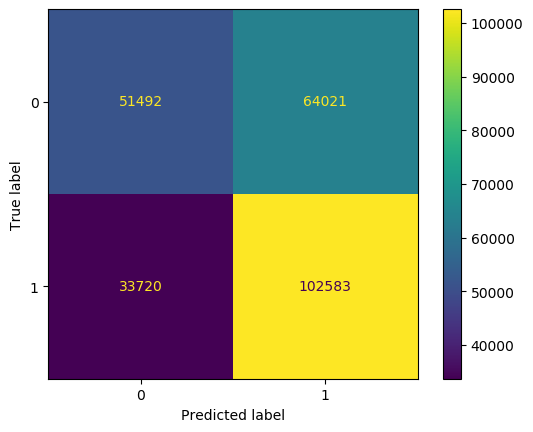

In [51]:
# visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=results, 
                              display_labels=['0','1'])
disp.plot(values_format='')
plt.show()

In [56]:
# run classification report
from sklearn.metrics import classification_report
 
print(classification_report(rounded_predictions, target_values.to_numpy()))

              precision    recall  f1-score   support

           0       0.45      0.60      0.51     85212
           1       0.75      0.62      0.68    166604

    accuracy                           0.61    251816
   macro avg       0.60      0.61      0.60    251816
weighted avg       0.65      0.61      0.62    251816



# Clean-up
If you’re ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [57]:
xgb_predictor.delete_endpoint()